In [1]:
#import ROOT
import uproot
import matplotlib.pyplot as plt
import numpy as np
import scipy
from lmfit import minimize, Parameters, Model
from lmfit.models import GaussianModel, ExponentialModel, \
                         ThermalDistributionModel, StepModel #Modelli vari, l'ultimo è Fermi (o Bose)

In [3]:
def load_histo(dat_PATH):
    data = np.loadtxt(dat_PATH, skiprows=0, comments='==')
    noises_edges = np.zeros((int(data.shape[0]/2), data.shape[1]))       
    noises_values = np.zeros((int(data.shape[0]/2), data.shape[1]))      

    for i in range(int(data.shape[0]/2)):
        noises_edges[i] = (data[2 * i])
        noises_values[i] = (data[2 * i + 1])

    return noises_edges, noises_values


def rebin(data, factor):
    if len(data) % factor != 0:
        raise ValueError("Length of data must be divisible by factor.")
    rebinned_data = np.sum(data.reshape(-1, factor), axis=1)
    return rebinned_data

In [3]:
PATH = '../../Dati/Run_Cs_batches_bis_Measurements_Only_5_29_2024_0003.root' #Percorso relativo del file da analizzare
#PATH = '../Dati/27_03/Run_ch4_Cs_Measurements_Only_4_21_2024_0000.root' #Percorso relativo del file da analizzare
#PATH = '../Dati/27_03/Run_ch7_Cs_Measurements_Only_3_27_2024_0000.root' #Percorso relativo del file da analizzare


RunCs = uproot.open(PATH) #Apertura file da analizzare



In [4]:
channel_idx = [0,  1, 2, 3, 4, 5, 6, 7,  8, 9,  10, 11, 12, -1, 13,14]

In [5]:
#Estrazione dati da file 

chargeCs = np.array(RunCs['tree'].arrays()['charge'][1:-1])
ampCs = np.array(RunCs['tree'].arrays()['amp'][1:-1])




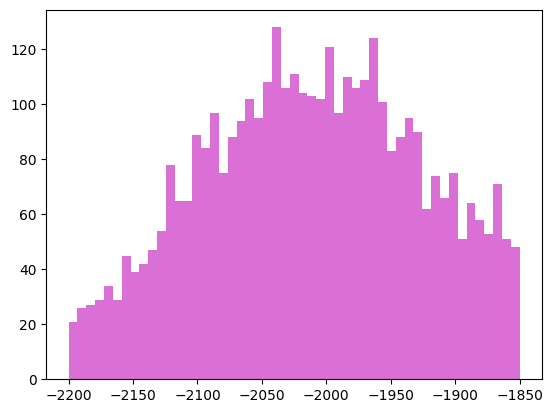

In [149]:
channel=15
lim_list = [[-690, -590],  #ch0
            [-645, -545],      #ch1      #èsbaglaito
            [-2500, -2150],  #ch2
            [-1510, -1320],  #ch3
            [-995, -895],  #ch4
            [-1750, -1490],  #ch5
            [-1190, -1000],  #ch6
            [-1700, -1479],  #ch7
            [-1400, -1110],  #ch8
            [-750, -520],  #ch9
            [-590, -520],  #ch10
            [-970, -790],  #ch11
            [-930, -750],      #ch12
            [-3000, -100],      #ch13
            [-1600, -1320],  #ch14
            [-2200, -1850]   #ch15
            ]

bin_N, edge_N, _=plt.hist(chargeCs[:,channel_idx[channel]], range=lim_list[channel],bins=51, color='orchid')
centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)


lim_N = lim_list[channel]
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

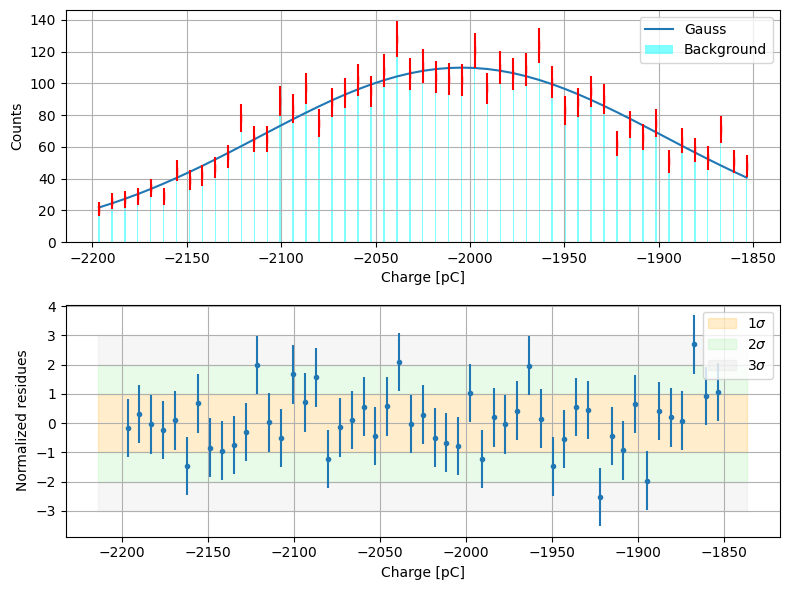

[[Model]]
    Model(gaussian, prefix='g3_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 51
    # variables        = 3
    chi-square         = 53.7733665
    reduced chi-square = 1.12027847
    Akaike info crit   = 8.70058590
    Bayesian info crit = 14.4960628
    R-squared          = 0.89811777
[[Variables]]
    g3_amplitude:  29470.6363 +/- 591.636367 (2.01%) (init = 35247.05)
    g3_center:    -2004.21375 +/- 2.45775128 (0.12%) (init = -2014.461)
    g3_sigma:      106.913696 +/- 2.76373567 (2.59%) (init = 109.8039)
    g3_fwhm:       251.762511 +/- 6.50810001 (2.59%) == '2.3548200*g3_sigma'
    g3_height:     109.967982 +/- 2.54173018 (2.31%) == '0.3989423*g3_amplitude/max(1e-15, g3_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(g3_amplitude, g3_sigma)  = +0.5174
    C(g3_center, g3_sigma)     = +0.3123
    C(g3_amplitude, g3_center) = +0.2385


In [150]:
#picco del fotoelettrico

sist_lims = lim_N
sist_bin = bin_N
sist_cntr = centers_N
sist_err = np.sqrt(sist_bin)


gauss3 = GaussianModel(prefix='g3_')    #Gaussiana

params2 = gauss3.guess(sist_bin, x = sist_cntr)           #Inizializzo i parametri dell'esponenziale

model2 = gauss3

result2 = model2.fit(sist_bin, params2, x = sist_cntr, weights = 1 / sist_err, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.bar(sist_cntr, sist_bin, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result2.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(sist_cntr, comps['g3_'], label='Gauss')

ax1.legend()
ax1.errorbar(sist_cntr, sist_bin, sist_err, color = "red", fmt='|')
ax1.grid()

residueGauss = sist_bin - result2.best_fit
norm_res_gauss = residueGauss / sist_err

ax2.errorbar(sist_cntr, norm_res_gauss, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()


print(result2.fit_report())

In [151]:
from math import nan


peak=[ -632.74, -591.12, -2295.01,-1412.10,-952.76,-1582.80,-1063.49,-1582.58,-1234.51,-672.83,-551.96,-857.91,-824.32,nan,-1435.02,-2004.21]
err_peak=[1.12, 1.31, 1.47,1.68,2.00,2.9,1.89,1.60,2.21,0.82,0.78,1.44,1.28,nan,1.89,2.45]
sigma=[36.59, 49.23,  111.7,83.10,51.0,95.22,60.11,72.74,101.0,48.72,29.62,64.34,53.38,nan,87.10,106.91]
err_sigma=[1.44, 1.93,1.64,2.77,3.48,3.21,1.80,1.99,2.73,1.02,1.21,1.61,1.36,nan,2.07,2.76]
